In [48]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt


In [49]:
def resize_image(image):
    return cv2.resize(image, (300, 300), interpolation=cv2.INTER_AREA)

def apply_gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def get_skin_mask_hsv(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_skin = (0, 20, 70)
    upper_skin = (20, 255, 255)
    return cv2.inRange(hsv_image, lower_skin, upper_skin)

def get_skin_mask_ycrcb(image):
    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    lower_skin = (0, 135, 85)
    upper_skin = (255, 180, 135)
    return cv2.inRange(ycrcb_image, lower_skin, upper_skin)

def equalize_histogram(image):
    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    channels = cv2.split(ycrcb_image)
    channels[0] = cv2.equalizeHist(channels[0])
    return cv2.cvtColor(cv2.merge(channels), cv2.COLOR_YCrCb2BGR)

# has no effect on used images
def remove_shadows(image):
    
    return image
    # lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # l_channel, a_channel, b_channel = cv2.split(lab_image)
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # l_channel = clahe.apply(l_channel)
    # lab_image = cv2.merge((l_channel, a_channel, b_channel))
    # return cv2.cvtColor(lab_image, cv2.COLOR_LAB2BGR)

def apply_adaptive_threshold(gray_image):
    return cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)


def preprocess_image(image):
    resized_image = resize_image(image)
    blurred_image = apply_gaussian_blur(resized_image)

    # Remove shadows and enhance brightness
    shadow_removed_image = remove_shadows(blurred_image)
    # shadow_removed_image = blurred_image

    hsv_mask = get_skin_mask_hsv(shadow_removed_image)
    ycrcb_mask = get_skin_mask_ycrcb(shadow_removed_image)

    skin_mask = cv2.bitwise_and(hsv_mask, ycrcb_mask)

    # Apply morphological operations to improve the skin mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    skin_mask = cv2.erode(skin_mask, kernel, iterations=2)
    skin_mask = cv2.dilate(skin_mask, kernel, iterations=2)

    # Apply the skin mask to the original image
    skin_segment = cv2.bitwise_and(shadow_removed_image, shadow_removed_image, mask=skin_mask)

    # Convert the skin segment to grayscale and apply adaptive thresholding
    gray_image = cv2.cvtColor(skin_segment, cv2.COLOR_BGR2GRAY)
    thresh_image = apply_adaptive_threshold(gray_image)

    return thresh_image


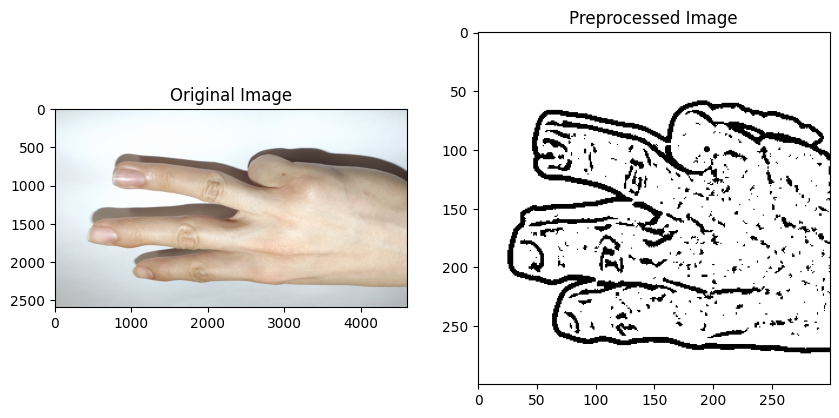

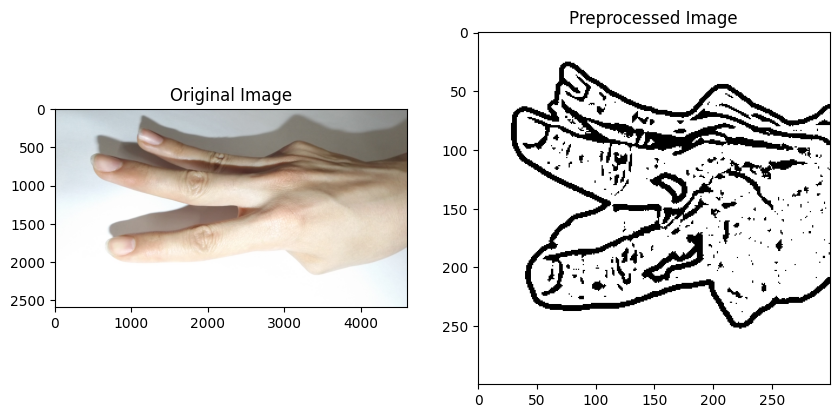

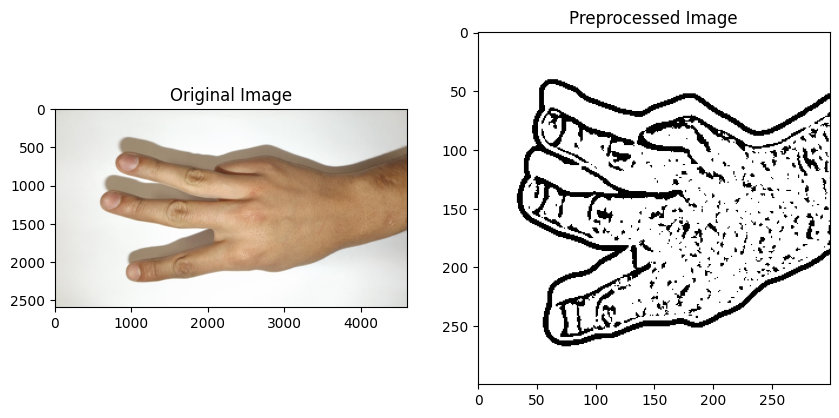

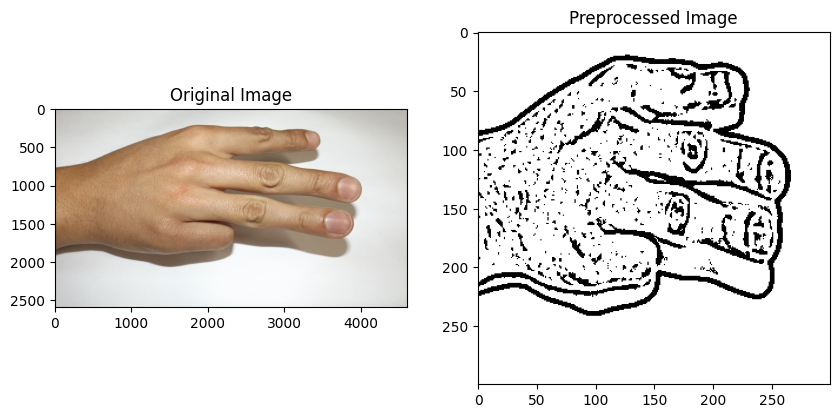

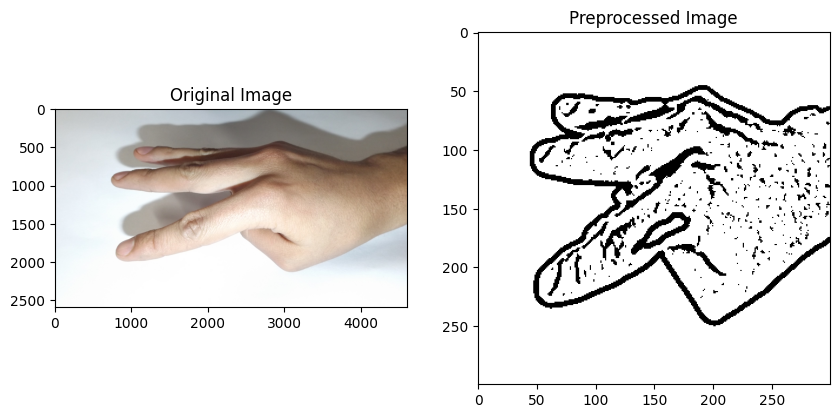

In [50]:
def test_stages(channel, index):
    # Load a sample images from the dataset

    sample_image_path = 'dataset/men/' + channel + '/' + channel + '_men (' + str(index) + ').JPG'
    img = cv2.imread(sample_image_path)

    # Preprocess the image
    preprocessed_image = preprocess_image(img)


    # Display the original, preprocessed images and features
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[1].imshow(preprocessed_image, cmap='gray')
    axes[1].set_title("Preprocessed Image")
    plt.show()

# Test the stages of the preprocessing pipeline by atterating over the channel with 5 indexes
for index in range(1, 6):
    test_stages(str(3), str(index))